In [1]:
from IPython.display import Image     #This is used for rendering images in the notebook

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import RepeatVector

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from scipy.stats import describe
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
from time import gmtime, strftime
from tensorflow.keras.callbacks import TensorBoard
import re
#from nltk.corpus import reuters
# Needed to run only once
nltk.download('punkt')
nltk.download('reuters')
from nltk.corpus import reuters

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [ ]:
%%capture
#!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [ ]:
def lookup_word2id(word):
    try:
        return word2id[word]
    except KeyError:
        return word2id["UNK"]


In [ ]:
def load_glove_vectors(glove_file, word2id, embed_size):
    embedding = np.zeros((len(word2id), embed_size))
    fglove = open(glove_file, "rb")
    for line in fglove:
        cols = line.strip().split()
        word = cols[0].decode('utf-8')
        if embed_size == 0:
            embed_size = len(cols) - 1
        if word in word2id:
            vec = np.array([float(v) for v in cols[1:]])
        embedding[lookup_word2id(word)] = vec
    embedding[word2id["PAD"]] = np.zeros((embed_size))
    embedding[word2id["UNK"]] = np.random.uniform(-1, 1, embed_size)
    return embedding


In [ ]:
def sentence_generator(X, embeddings, batch_size):
    while True:
        # loop once per epoch
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            sids = indices[bid * batch_size: (bid + 1) * batch_size]
            Xbatch = embeddings[X[sids, :]]
            yield Xbatch, Xbatch

In [ ]:
def compute_cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))


In [ ]:
def is_number(n):
    temp = re.sub("[.,-/]", "",n)
    return temp.isdigit()

# parsing sentences and building vocabulary
word_freqs = collections.Counter()
documents = reuters.fileids()
#ftext = open("text.tsv", "r")
sents = []
sent_lens = []
num_read = 0
for i in range(len(documents)):
    # periodic heartbeat report
    if num_read % 100 == 0:
        print("building features from {:d} docs".format(num_read))
    # skip docs without specified topic
    title_body = reuters.raw(documents[i]).lower()
    if len(title_body) == 0:
        continue
    num_read += 1
    # convert to list of word indexes
    title_body = re.sub("\n", "", title_body)
    for sent in nltk.sent_tokenize(title_body):
        for word in nltk.word_tokenize(sent):
            if is_number(word):
                word = "9"
            word = word.lower()
            word_freqs[word] += 1
        sents.append(sent)
        sent_lens.append(len(sent))

#ftext.close()

building features from 0 docs
building features from 100 docs
building features from 200 docs
building features from 300 docs
building features from 400 docs
building features from 500 docs
building features from 600 docs
building features from 700 docs
building features from 800 docs
building features from 900 docs
building features from 1000 docs
building features from 1100 docs
building features from 1200 docs
building features from 1300 docs
building features from 1400 docs
building features from 1500 docs
building features from 1600 docs
building features from 1700 docs
building features from 1800 docs
building features from 1900 docs
building features from 2000 docs
building features from 2100 docs
building features from 2200 docs
building features from 2300 docs
building features from 2400 docs
building features from 2500 docs
building features from 2600 docs
building features from 2700 docs
building features from 2800 docs
building features from 2900 docs
building features from

In [ ]:
print("Total number of sentences are: {:d} ".format(len(sents)))
print ("Sentence distribution min {:d}, max {:d} , mean {:3f}, median {:3f}".
      format(np.min(sent_lens), np.max(sent_lens), np.mean(sent_lens), np.median(sent_lens)))
print("Vocab size (full) {:d}".format(len(word_freqs)))


Total number of sentences are: 50470 
Sentence distribution min 1, max 3688 , mean 167.072657, median 155.000000
Vocab size (full) 33748


In [ ]:
VOCAB_SIZE = 5000
EMBED_SIZE = 50
LATENT_SIZE = 512
SEQUENCE_LEN = 50

BATCH_SIZE = 64
NUM_EPOCHS = 20


In [ ]:
# word2id = collections.defaultdict(lambda: 1)
word2id = {}
word2id["PAD"] = 0
word2id["UNK"] = 1
for v, (k, _) in enumerate(word_freqs.most_common(VOCAB_SIZE - 2)):
    word2id[k] = v + 2
id2word = {v: k for k, v in word2id.items()}

print("vocabulary sizes:", len(word2id), len(id2word))

sent_wids = [[lookup_word2id(w) for w in s.split()] for s in sents]
sent_wids = sequence.pad_sequences(sent_wids, SEQUENCE_LEN)

# load glove vectors into weight matrix
embeddings = load_glove_vectors("glove.6B.{:d}d.txt".format(EMBED_SIZE), word2id, EMBED_SIZE)
print(embeddings.shape)

# split sentences into training and test
train_size = 0.7
Xtrain, Xtest = train_test_split(sent_wids, train_size=train_size)
print("number of sentences: ", len(sent_wids))
print(Xtrain.shape, Xtest.shape)

vocabulary sizes: 5000 5000
(5000, 50)
number of sentences:  50470
(35329, 50) (15141, 50)


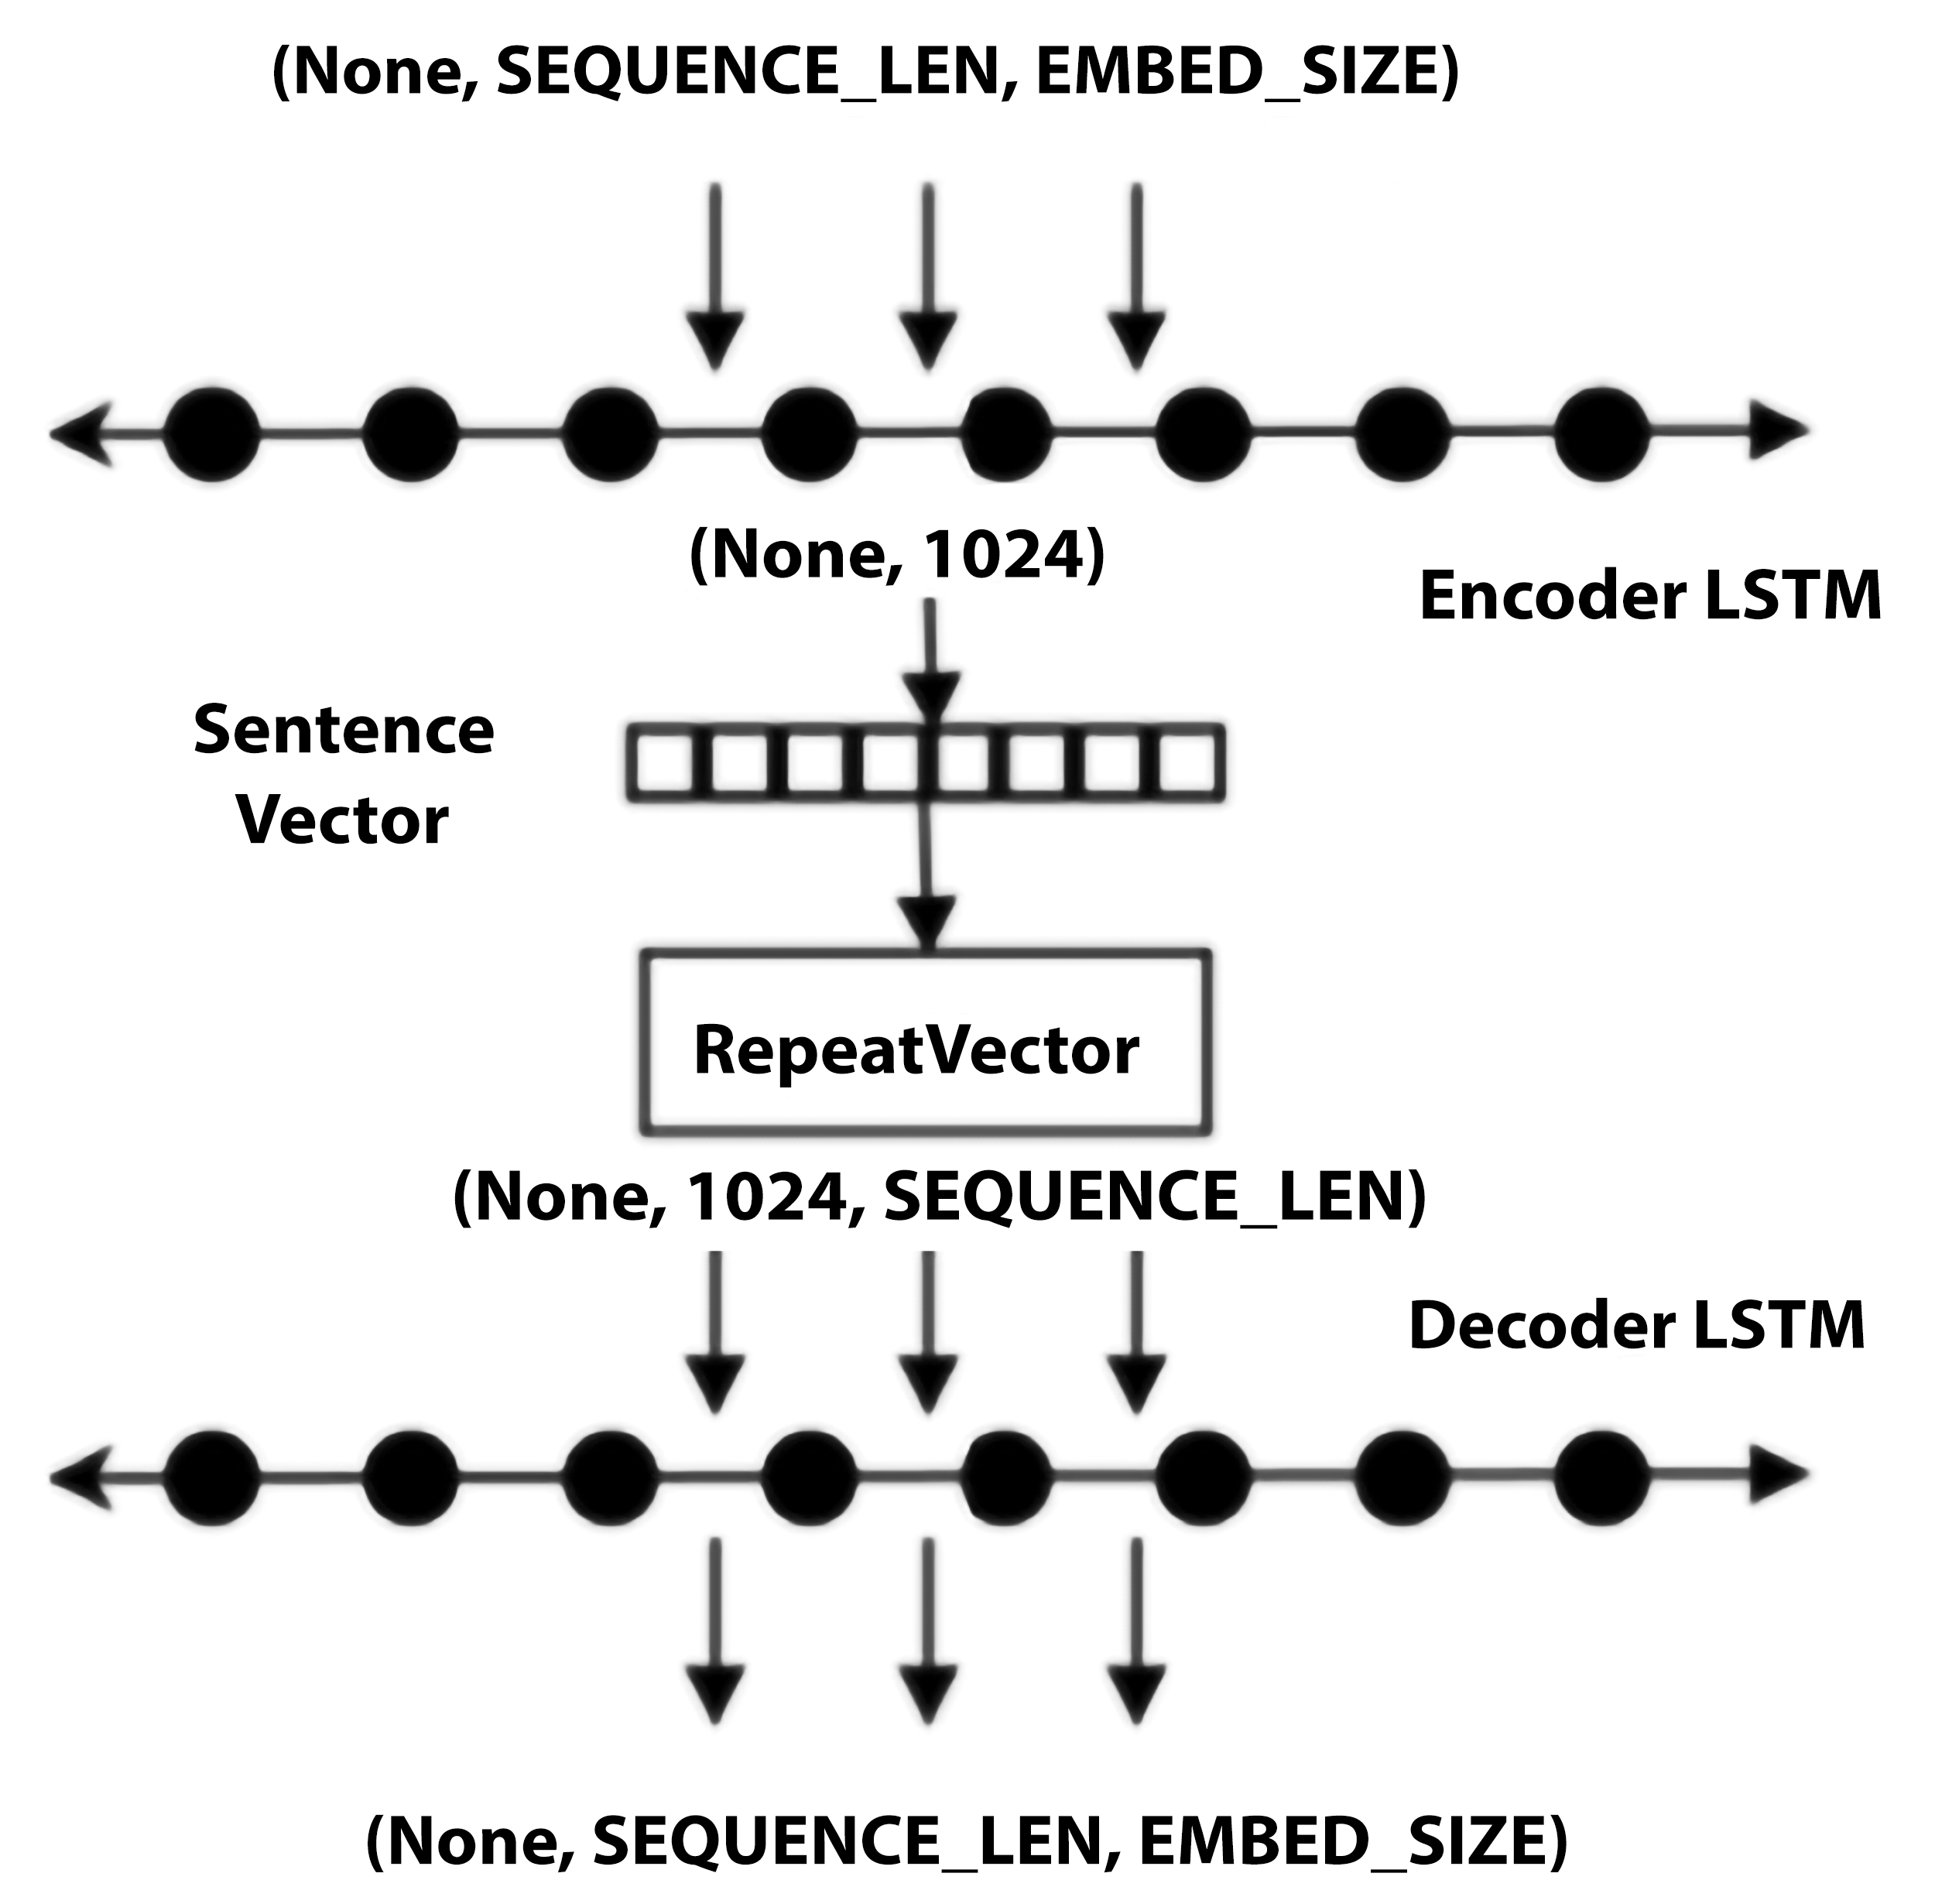

In [2]:
Image('/content/B18331_08_11.png', width=600) #This is used for rendering

In [ ]:
# define training and test generators
train_gen = sentence_generator(Xtrain, embeddings, BATCH_SIZE)
test_gen = sentence_generator(Xtest, embeddings, BATCH_SIZE)

In [ ]:
# define autoencoder network
inputs = Input(shape=(SEQUENCE_LEN, EMBED_SIZE), name="input")
encoded = Bidirectional(LSTM(LATENT_SIZE), merge_mode="sum",
                        name="encoder_lstm")(inputs)
decoded = RepeatVector(SEQUENCE_LEN, name="repeater")(encoded)
decoded = Bidirectional(LSTM(EMBED_SIZE, return_sequences=True),
                        merge_mode="sum",
                        name="decoder_lstm")(decoded)

autoencoder = Model(inputs, decoded)

#tensorboard = make_tensorboard(set_dir_name='rnn')

In [ ]:
autoencoder.compile(optimizer="adam", loss="mse")

# train
num_train_steps = len(Xtrain) // BATCH_SIZE
num_test_steps = len(Xtest) // BATCH_SIZE
#checkpoint = ModelCheckpoint(
#   filepath=os.path.join(DATA_DIR, "sent-thoughts-autoencoder.h5"),
#    save_best_only=True)
history = autoencoder.fit_generator(train_gen,
                                    steps_per_epoch=num_train_steps,
                                    epochs=NUM_EPOCHS,
                                    validation_data=test_gen,
                                    validation_steps=num_test_steps) 
                                    #callbacks=[checkpoint, tensorboard])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
552/552 [==============================] - 25s 34ms/step - loss: 0.1842 - val_loss: 0.1721
Epoch 2/20
552/552 [==============================] - 18s 32ms/step - loss: 0.1697 - val_loss: 0.1655
Epoch 3/20
552/552 [==============================] - 18s 32ms/step - loss: 0.1652 - val_loss: 0.1628
Epoch 4/20
552/552 [==============================] - 18s 32ms/step - loss: 0.1621 - val_loss: 0.1592
Epoch 5/20
552/552 [==============================] - 18s 32ms/step - loss: 0.1591 - val_loss: 0.1566
Epoch 6/20
552/552 [==============================] - 18s 32ms/step - loss: 0.1561 - val_loss: 0.1533
Epoch 7/20
552/552 [==============================] - 18s 34ms/step - loss: 0.1538 - val_loss: 0.1519
Epoch 8/20
552/552 [==============================] - 18s 32ms/step - loss: 0.1514 - val_loss: 0.1492
Epoch 9/20
552/552 [==============================] - 18s 32ms/step - loss: 0.1495 - val_loss: 0.1476
Epoch 10/20
552/552 [==============================] - 18s 32ms/step - loss: 0.147

In [ ]:
# collect autoencoder predictions for test set
test_inputs, test_labels = next(test_gen)
preds = autoencoder.predict(test_inputs)

# extract encoder part from autoencoder
encoder = Model(autoencoder.input,
                autoencoder.get_layer("encoder_lstm").output)
# encoder.summary()


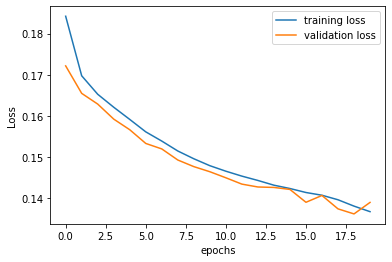

In [ ]:
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# compute difference between vector produced by original and autoencoded
k = 500
cosims = np.zeros((k))
i = 0
for bid in range(num_test_steps):
    xtest, ytest = next(test_gen)
    ytest_ = autoencoder.predict(xtest)
    Xvec = encoder.predict(xtest)
    Yvec = encoder.predict(ytest_)
    for rid in range(Xvec.shape[0]):
        if i >= k:
            break
        cosims[i] = compute_cosine_similarity(Xvec[rid], Yvec[rid])
        if i <= 10:
            print(cosims[i])
        i += 1
    if i >= k:
        break

0.9765363335609436
0.9862152338027954
0.9831727743148804
0.977733314037323
0.9851642847061157
0.9849132895469666
0.9831638932228088
0.9843543767929077
0.9825796484947205
0.9877195954322815
0.9820773601531982


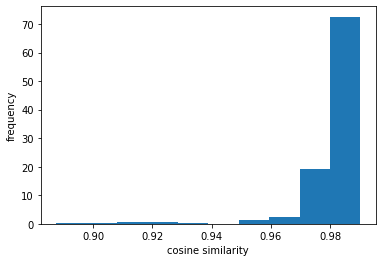

In [ ]:
plt.hist(cosims, bins=10, density=True)
plt.xlabel("cosine similarity")
plt.ylabel("frequency")
plt.show()